 ## Basic mobility model

 Step 1: Define Zones

In [21]:
import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np


In [36]:

zone_ids = ['Mellila', 'CapeTown', 'Freetown', 'Madrid']
populations = [1000, 800, 1200, 1600]
jobs = [1500, 700, 400, 1000]
coordinates = [(0, 0), (1, 2), (3, 1), (4, 3)]

zone_df = pd.DataFrame({
    'zone_id': zone_ids,
    'populations': populations,
    'jobs': jobs,
    'x': [pt[0] for pt in coordinates],
    'y': [pt[1] for pt in coordinates]
})

Step 2: Compute Distance Matrix

In [37]:
coords = list(zip(zone_df['x'], zone_df['y']))
dist_matrix = pd.DataFrame(cdist(coords, coords), columns=zone_ids, index=zone_ids)
print (dist_matrix)

           Mellila  CapeTown  Freetown    Madrid
Mellila   0.000000  2.236068  3.162278  5.000000
CapeTown  2.236068  0.000000  2.236068  3.162278
Freetown  3.162278  2.236068  0.000000  2.236068
Madrid    5.000000  3.162278  2.236068  0.000000


In [38]:
np.random.seed(42)
travel_cost_matrix = dist_matrix * 1.5 + np.random.uniform(0.1, 1.0, size=dist_matrix.shape)
travel_cost_matrix = pd.DataFrame(travel_cost_matrix, columns=zone_ids, index=zone_ids)
print (travel_cost_matrix)

           Mellila  CapeTown  Freetown    Madrid
Mellila   0.437086  4.309745  5.502211  8.138793
CapeTown  3.594519  0.240395  3.506377  5.622975
Freetown  5.384420  4.091367  0.118526  4.327021
Madrid    8.349198  5.034522  3.617744  0.265064


Step 4: Gravity Model with Decay

In [39]:
alpha, beta, lambda_decay = 1, 1, 0.5
flows = pd.DataFrame(index=zone_ids, columns=zone_ids, dtype=float)


for i in zone_ids:
    for j in zone_ids:
        if i != j:
            pop_i = zone_df.loc[zone_df['zone_id'] == i, 'populations'].values[0]
            jobs_j = zone_df.loc[zone_df['zone_id'] == j, 'jobs'].values[0]
            cost = travel_cost_matrix.loc[i, j]
            decay = np.exp(-lambda_decay * cost)
            flows.loc[i, j] = (pop_i ** alpha * jobs_j ** beta) * decay
        else:
            flows.loc[i, j] = 0.0
print(flows)


                Mellila       CapeTown       Freetown         Madrid
Mellila        0.000000   81142.584858   25542.890719   17087.700934
CapeTown  198903.038935       0.000000   55430.633223   48092.402716
Freetown  121915.958606  108605.087074       0.000000  137905.189879
Madrid     36915.253070   90361.936233  104856.836510       0.000000


 Step 5: Normalize Total Flows

In [40]:
flows = flows / flows.values.sum() * 10000  # total trips = 10,000
print (flows)


              Mellila     CapeTown     Freetown       Madrid
Mellila      0.000000   790.278384   248.771893   166.423595
CapeTown  1937.192073     0.000000   539.859943   468.390135
Freetown  1187.385723  1057.746100     0.000000  1343.110905
Madrid     359.531639   880.069141  1021.240468     0.000000


(-1.0, 5.0)

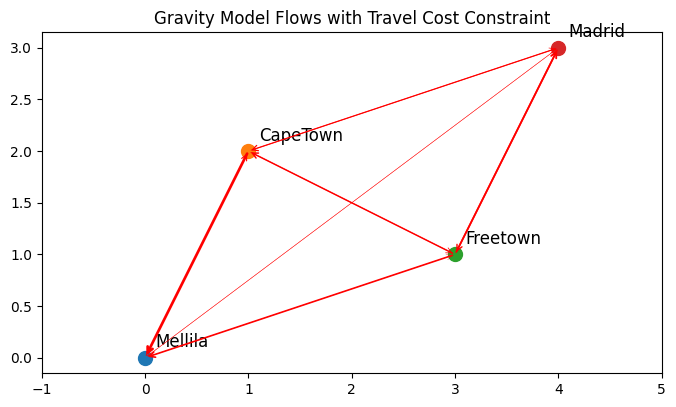

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Plot zone points
for i, row in zone_df.iterrows():
    ax.scatter(row['x'], row['y'], s=100)
    ax.text(row['x'] + 0.1, row['y'] + 0.1, row['zone_id'], fontsize=12)

# Draw arrows for flows above threshold
threshold = 50
for i in zone_ids:
    for j in zone_ids:
        flow = flows.loc[i, j]
        if flow > threshold:
            xi = zone_df.loc[zone_df['zone_id'] == i, 'x'].values[0]
            yi = zone_df.loc[zone_df['zone_id'] == i, 'y'].values[0]
            xj = zone_df.loc[zone_df['zone_id'] == j, 'x'].values[0]
            yj = zone_df.loc[zone_df['zone_id'] == j, 'y'].values[0]
            ax.annotate("",
                        xy=(xj, yj),
                        xytext=(xi, yi),
                        arrowprops=dict(arrowstyle="->", lw=flow / 1000, color='red'))

ax.set_title("Gravity Model Flows with Travel Cost Constraint")
ax.set_aspect('equal')
ax.set_xlim(-1, 5)

(-1.0, 5.0)

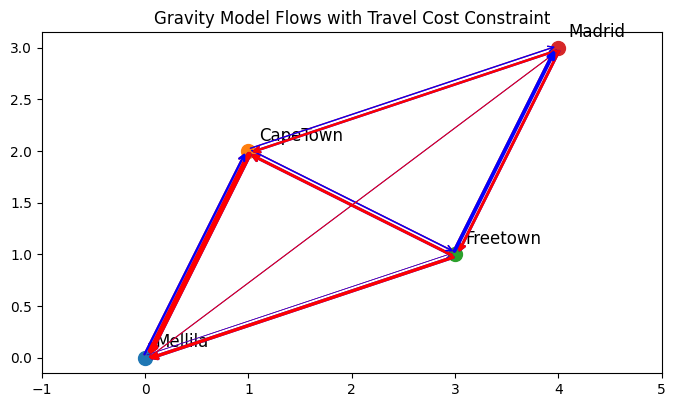

In [48]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))

# Plot zone points
for i, row in zone_df.iterrows():
    ax.scatter(row['x'], row['y'], s=100)
    ax.text(row['x'] + 0.1, row['y'] + 0.1, row['zone_id'], fontsize=12)

threshold = 200
offset_distance = 0.02  # Adjust for more/less separation

for i in zone_ids:
    for j in zone_ids:
        if i == j:
            continue  # skip self-flows

        flow_ij = flows.loc[i, j]
        flow_ji = flows.loc[j, i]

        xi = zone_df.loc[zone_df['zone_id'] == i, 'x'].values[0]
        yi = zone_df.loc[zone_df['zone_id'] == i, 'y'].values[0]
        xj = zone_df.loc[zone_df['zone_id'] == j, 'x'].values[0]
        yj = zone_df.loc[zone_df['zone_id'] == j, 'y'].values[0]

        # Vector from i to j
        dx = xj - xi
        dy = yj - yi
        length = np.hypot(dx, dy)

        if length == 0:
            continue  # avoid division by zero

        # Perpendicular unit vector
        perp_dx = -dy / length
        perp_dy = dx / length

        # Offset coordinates
        if flow_ij > threshold:
            ax.annotate("",
                        xy=(xj + perp_dx * offset_distance, yj + perp_dy * offset_distance),
                        xytext=(xi + perp_dx * offset_distance, yi + perp_dy * offset_distance),
                        arrowprops=dict(arrowstyle="->", lw=flow_ij / 500, color='red'))

        if flow_ji > threshold:
            ax.annotate("",
                        xy=(xi - perp_dx * offset_distance, yi - perp_dy * offset_distance),
                        xytext=(xj - perp_dx * offset_distance, yj - perp_dy * offset_distance),
                        arrowprops=dict(arrowstyle="->", lw=flow_ji / 500, color='blue'))

ax.set_title("Gravity Model Flows with Travel Cost Constraint")
ax.set_aspect('equal')
ax.set_xlim(-1, 5)


In [29]:
from ipywidgets import interact, FloatSlider

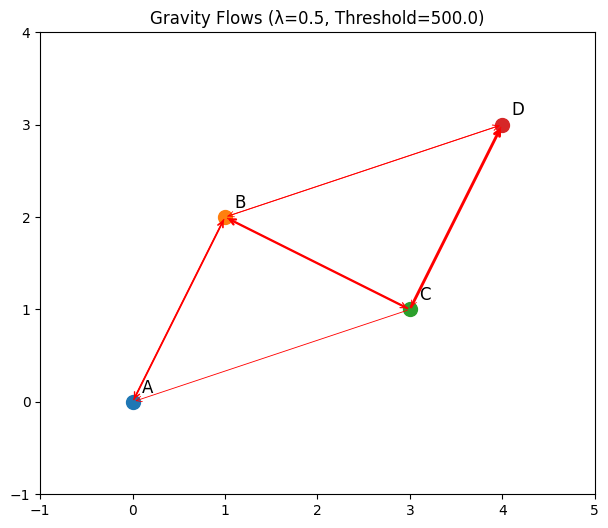

interactive(children=(FloatSlider(value=0.5, description='λ (decay)', max=2.0, min=0.1), FloatSlider(value=500…

<function __main__.plot_flows(lambda_decay=0.5, threshold=500)>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from ipywidgets import interact, FloatSlider

# Define zones
zone_ids = ['A', 'B', 'C', 'D']
populations = [1000, 800, 1200, 600]
jobs = [500, 700, 400, 1000]
coordinates = [(0, 0), (1, 2), (3, 1), (4, 3)]

zone_df = pd.DataFrame({
    'zone_id': zone_ids,
    'population': populations,
    'jobs': jobs,
    'x': [pt[0] for pt in coordinates],
    'y': [pt[1] for pt in coordinates]
})

# Distance and travel cost
coords = list(zip(zone_df['x'], zone_df['y']))
dist_matrix = pd.DataFrame(cdist(coords, coords), columns=zone_ids, index=zone_ids)
np.random.seed(42)
travel_cost_matrix = dist_matrix * 1.5 + np.random.uniform(0.1, 1.0, size=dist_matrix.shape)
travel_cost_matrix = pd.DataFrame(travel_cost_matrix, columns=zone_ids, index=zone_ids)

# Gravity model plot function
def plot_flows(lambda_decay=0.5, threshold=500):
    alpha, beta = 1, 1
    flows = pd.DataFrame(index=zone_ids, columns=zone_ids, dtype=float)

    for i in zone_ids:
        for j in zone_ids:
            if i != j:
                pop_i = zone_df.loc[zone_df['zone_id'] == i, 'population'].values[0]
                jobs_j = zone_df.loc[zone_df['zone_id'] == j, 'jobs'].values[0]
                cost = travel_cost_matrix.loc[i, j]
                decay = np.exp(-lambda_decay * cost)
                flows.loc[i, j] = (pop_i ** alpha * jobs_j ** beta) * decay
            else:
                flows.loc[i, j] = 0.0

    flows = flows / flows.values.sum() * 10000  # normalize

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, row in zone_df.iterrows():
        ax.scatter(row['x'], row['y'], s=100)
        ax.text(row['x'] + 0.1, row['y'] + 0.1, row['zone_id'], fontsize=12)

    for i in zone_ids:
        for j in zone_ids:
            flow = flows.loc[i, j]
            if flow > threshold:
                xi = zone_df.loc[zone_df['zone_id'] == i, 'x'].values[0]
                yi = zone_df.loc[zone_df['zone_id'] == i, 'y'].values[0]
                xj = zone_df.loc[zone_df['zone_id'] == j, 'x'].values[0]
                yj = zone_df.loc[zone_df['zone_id'] == j, 'y'].values[0]
                ax.annotate("",
                            xy=(xj, yj),
                            xytext=(xi, yi),
                            arrowprops=dict(arrowstyle="->", lw=flow / 1000, color='red'))

    ax.set_title(f"Gravity Flows (λ={lambda_decay}, Threshold={threshold})")
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 4)
    ax.set_aspect('equal')
    plt.show()

# Create sliders
interact(plot_flows,
         lambda_decay=FloatSlider(value=0.5, min=0.1, max=2.0, step=0.1, description='λ (decay)'),
         threshold=FloatSlider(value=500, min=0, max=2000, step=100, description='Min flow'))

In [31]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(min=0, max=10, step=1, description='Slide me:')
display(slider)

IntSlider(value=0, description='Slide me:', max=10)

In [32]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)